<a href="https://colab.research.google.com/github/modichirag/sbi_tutorial/blob/main/SBI_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch


In [6]:
# install emcee that we will use for mcmc sampling
!pip install --quiet emcee


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 754.4 kB/s eta 0:00:00


In [7]:
# install sbi that we will use for, well...sbi
!pip install  --quiet  sbi


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.3/272.3 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.8/732.8 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


# 1-D Toy problem

Let's set up a simple 1-dimensional toy problem to get started with SBI.  

Say we are interested in the estimating the age of a person ($\theta: age$) given their height $(x: height)$.

To keep things simple, we will assume that the height of the person is distributed as a Gaussian distribution where the mean and the variance of the distribution depend on the age of the person depend as follows:

$height \sim \mathcal{N}(\mu, \sigma^2)$ \\
where \\
$\mu = - 0.04 *(age - 60)^2 + 170$ \\
$\sigma^2 = - 0.04 *(age - 60)^2 + 170$ \\

Though not relevant for the turorial, this ad-hoc relation captures some of the intuition we might have about height-age relationship, for e.g., \\
- it gets the average height of a baby and a 60 year old reasonably correct
- the height of the person increases faster when young and asymptotes as they mature followed by a slight decrease as they stoop in the old age (say after age 60)
- the variance in the height is larger when the mean height is larger  

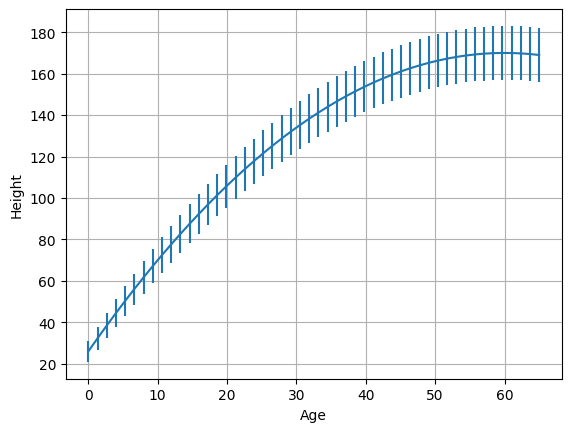

In [16]:
def mean_height(age):
    h = -0.04*(age - 60)**2 + 170
    return h

def var_height(age):
    h = -0.04*(age - 60)**2 + 170
    return h

#Let us visualize what this distribution looks like
ages = np.linspace(0, 65)
h_mean = mean_height(ages)
h_var = var_height(ages)
plt.errorbar(ages, h_mean, h_var**0.5)
plt.xlabel('Age')
plt.ylabel('Height')
plt.grid()

This defines a data-generating process, or a simulator which takes in the age and outputs a height of the person.

In [13]:
def simulator(age):
    # Generate samples from N(mu, sigma) where mu and sigma depend on age

    mu = mean_height(age)
    var = var_height(age)

    # Just some book-keeping to handle both scalar and vector inputs.
    if type(age) == float:
        h = mu + var**0.5 * np.random.normal()
    elif type(age) == np.ndarray :
        h = mu + var**0.5 * np.random.normal(size=mu.shape[0])
    return h


# lets generate some sampled data from this simulator
# we assume a prior distribution on our ages between 0 and 65
age_samples = np.random.uniform(0, 65, 1000)
height_samples = simulator(age_samples)

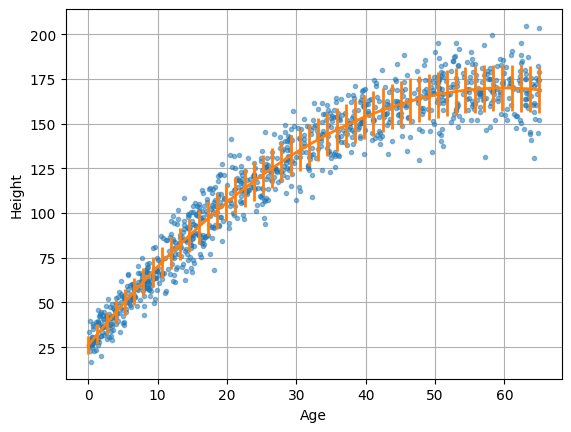

In [17]:
plt.plot(age_samples, height_samples, '.', alpha=0.5)
plt.errorbar(ages, h_mean, h_var**0.5, lw=2)
plt.xlabel('Age')
plt.ylabel('Height')
plt.grid()

## Explicit inference with MCMC

Given an observation of height (data), we wish to infer the age of the person i.e. we are interested in estimating the posterior distribution $p(\theta | x)$

According to Baye's theorem:
$p(\theta | x) \propto p(x | \theta) \times p(\theta) $

The likelihood distribution of the observed data (height) is described above:  p(x | \theta). \\
We also need a prior distribution on $\theta$, the parameters of interest i.e. age.
Let us assume this to be a uniform distribution
$\theta \sim \mathcal{U}(0, 65)$

In [18]:
def log_likelihood(theta, x):
    mu = mean_height(theta)
    var = var_height(theta)
    lk =   -0.5* ((mu-x)**2)/var
    return lk

def log_prior(theta):
    lp = 0
    if (theta < 0) or (theta > 65): lp = -np.inf
    else: lp = 0.
    return lp

def log_prob(theta, x):
    lk = log_likelihood(theta, x)
    lp = log_prior(theta)
    log_prob = lk + lp
    return log_prob


Let us construct a mock data for say a person of age 20.

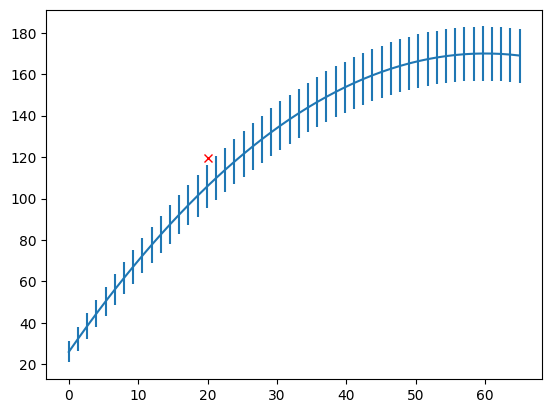

In [99]:
np.random.seed(10)
age = 20.
height = simulator(age)

# Visualize the data
plt.errorbar(ages, h_mean, h_var**0.5)
plt.plot(age, height, 'x', color='red')

### Sampling

Now that we have defined the posterior distribution and generated a mock data sample, we can use MCMC to generate samples from the posterior i.e. the possible ages consistent with the observed height.

We will use emcee package for this which is a great package of small (< 10) dimensional problems.

https://emcee.readthedocs.io/en/stable/

In [20]:
import emcee

In [100]:
# the dimensionality of the problem, and the number of walkers we want to use
ndim, nwalkers = 1, 10

# Initialize the emcee sampler for our problem
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[height])

# generate an initial guess from the prior
p0 = np.random.uniform(0, 65, nwalkers).reshape(-1, 1)

# do a warm-up/burn-in to allow the generated points to come into the posterior
# we do this for 1000 steps since it is a simple 1-D problem
state = sampler.run_mcmc(p0, 1000)

# reset to clear the previous samples except the last one
# then do the acutual sampling for 1000 steps
sampler.reset()
state = sampler.run_mcmc(state, 1000)
samples = sampler.get_chain() # the output shape will be (samples, chain, dim)

Lets visualize these chains to make sure they have mixed well

(1000, 10, 1)


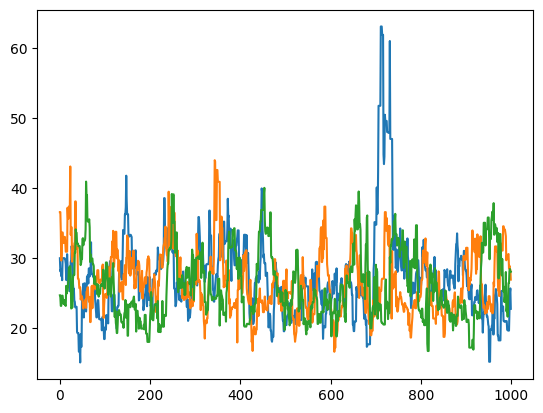

In [101]:
print(samples.shape)
plt.plot(samples[:, :3, 0]);

Finally, lets plot the final posterior distrbution

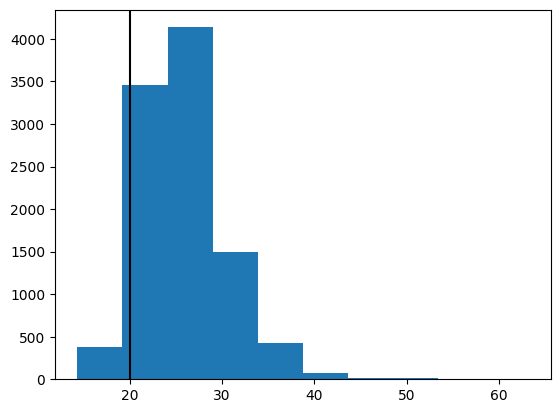

In [102]:
plt.hist(samples.flatten())
plt.axvline(age, color='k')

## Implicit inference with SBI

To do the explicit inference as we discussed above, we needed to know the likelihood distribution of the data (heights) conditioned on the parameters (age). Often we do not have access to it.

However many times we do have access to the samples from this likelihood distribution. This is precisely what a physical simulator gives you.

In this example, we will assume that we have this data from the simulator described above (or alternatively that you got these samples from surveying the population).
SBI allows us to do the inference in this setting.

Fundamentally, what you do is to use these samples to learn the amortized likelihood, or the posterior distribution using flexible models capable of learning density distributions. Generally, these models are _normalizing flows_ (but they do not necessarily have to be).

Here, we will conduct SBI using normalizing flows using `sbi`, an excellent python package. See
[Tejero-Cantero+(2020)](https://doi.org/10.21105/joss.02505) for details.



In [103]:
# Lets begin with some imports
import sbi.utils as utils
from sbi.inference.base import infer
from sbi import analysis
from sbi.inference import SNPE, SNLE_A #prepare_for_sbi, simulate_for_sbi

In [104]:
# We again need to set the priors, in this case using torch tensors.
# We simply use `sbi' package funcionality for this

prior = utils.BoxUniform(
    low=torch.tensor([0]),
    high=torch.tensor([65])
)


Lets define a normalizing flow model. This is the model that estimates the conditional probability distribution --- i.e. posterior. We can use either masked autoregressive flows (MAF; [Papamakarios+(2017)](https://ui.adsabs.harvard.edu/abs/2017arXiv170507057P/abstract)), or neural spline flows (https://arxiv.org/abs/1906.04032).

Here we use spline flows as the MAF only learns a Gaussian distribution in 1 dimension.
Since we're estimating a relatively simple example, we'll go with some random architecture


In [105]:
nhidden = 128
nblocks = 5

nf_model = utils.posterior_nn('nsf', hidden_features=nhidden, num_transforms=nblocks)

Now we can set up the SBI. Note that we use the SNPE module, which stands for Sequential Neural Posterior Estimation. We will *not* be using the sequential
feature, which allows us to sequentially generate more samples using our forward model. However, if you're interested the `sbi` package is fairly well documented with examples: https://www.mackelab.org/sbi/tutorial/16_implemented_methods/


Instead here we will generate the samples from the simulator beforehand and then use these to train SBI. In this way, the SBI pricedure is amortized i.e. once trained, it can be used with many new data points for inference.

Sequential approaches depend on data and in any round, they generate simulations for training more effectively in a region from the approximate posterior distribution of the previous round.

In [106]:
# generate simulations from the simulator
num_sims = 2000
theta = prior.sample((num_sims,))

x = simulator(theta[:, 0].numpy())
# some bookkeeping to change data into right shape and data-type
x = torch.from_numpy(x.reshape(-1, 1).astype(np.float32))


In [107]:
# Let us set-up the inference object now

method = 'SNPE' #SNPE or SNLE or SNRE
inference = SNPE(prior=prior,
                 density_estimator=nf_model)

# append the simulations to the inference object, and train
inference.append_simulations(theta, x)
density_estimator = inference.train(training_batch_size=64,
                                        validation_fraction=0.2,
                                        learning_rate=5e-4,
                                        show_train_summary=True)

# Conver the trained density estimator to posterior
posterior = inference.build_posterior()


 Neural network successfully converged after 42 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 42
        Best validation performance: -2.9374
        -------------------------
        


Okay, now we can use this learnt neural posterior to generate samples from the posterior distribution given any data, and comapre with what MCMC gave us.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

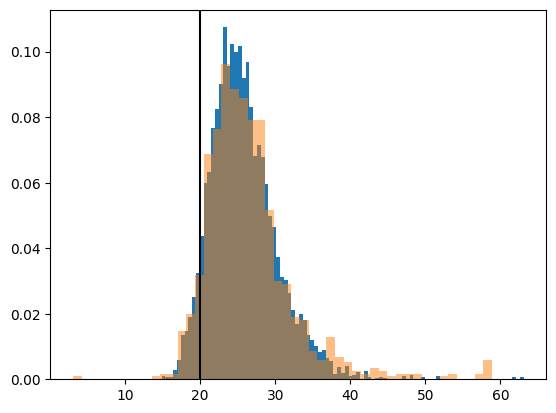

In [108]:
# our data was the height. Some boilerplate to convert it to a tensor of correct shape and datatype
test_data = torch.from_numpy(np.array([height]).astype(np.float32).reshape(-1, 1))
samples2 = posterior.sample((1000,), x=test_data).numpy().flatten()

plt.hist(samples.flatten(), density=True, bins='auto')
plt.hist(samples2, alpha=0.5, density=True, bins='auto')
plt.axvline(age, color='k')

# Cosmology example

Okay, now we turn to a more realistic example from cosmology.

We are interested in estimating the cosmology parameters from the power spectrum of the matter distribution in the Universe.

Data: We will use the power spectrum from the Quijote simulations. These generated 2000 simulations by varying the 5 cosmology parameters $\Omega_m$,$\Omega_b$,$h$,$n_s$,$\sigma_8$
over a broad range of parameters.

In [130]:
# Let us begin by loading the data
cosmonames = r'$\Omega_m$,$\Omega_b$,$h$,$n_s$,$\sigma_8$'.split(",")
params = np.load('params_quijote_lh.npy').astype(np.float32)
pk = np.load('pkmatter_quijote.npy').astype(np.float32)

# Remove the k-axis from the loader power spectrum table
k = pk[0, :, 0]
pk = pk[..., 1]

[]

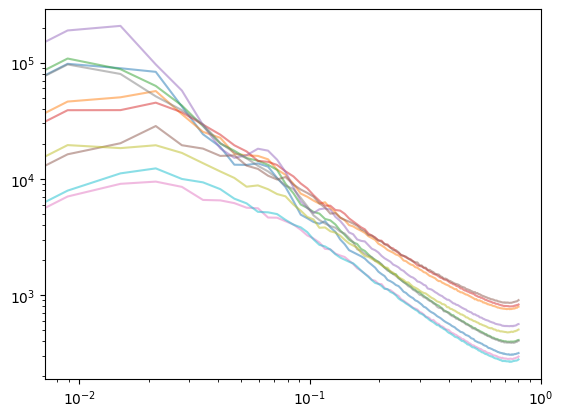

In [110]:
# Visualize the data

for i in range(10):
    plt.plot(k, pk[i],)
plt.loglog()

We again begin by constructing the prior on our parameters.

In this case, our prior is defined by the training dataset which is generated by Quijote simulations. These simulations generated a Latin-hypercube over a fixed parameter range, which essentially imposes a uniform distribution as prior over these ranges.


In [111]:
lower_bound, upper_bound = params.min(axis=0), params.max(axis=0)
print(list(zip(cosmonames, lower_bound, upper_bound)))

lower_bound, upper_bound = (torch.from_numpy(lower_bound.astype('float32')),
                            torch.from_numpy(upper_bound.astype('float32')))
prior = utils.BoxUniform(lower_bound, upper_bound)


[('$\\Omega_m$', 0.1001, 0.4999), ('$\\Omega_b$', 0.03001, 0.06999), ('$h$', 0.5001, 0.8999), ('$n_s$', 0.8001, 1.1999), ('$\\sigma_8$', 0.6001, 0.9999)]


Now we split the generated simulations into 2 parts- training and testing. \\
(sbi package includes validation dataset in the training dataset)

We will use 1700 simulations (85%) for training, and 300 (15%) for testing.

We will also do a scale cut to process the data and use only the power spectrum upto $k=0.5 h/Mpc$.

In [112]:
nsims = 1700

# find the k-index where k > 0.5
k_idx = np.where(k > 0.5)[0][0]

train_p, train_x = params[:nsims], pk[:nsims, 1:k_idx]
test_p, test_x = params[nsims:], pk[nsims:, 1:k_idx]


Finally we are ready to do SBI. We will basically repeat the same steps as before.

In [115]:
# Let us set-up the inference object now

# first define the density estimator. This time we will use a masked autoregresive flow
nhidden = 128
nblocks = 5
nf_model = utils.posterior_nn('maf', hidden_features=nhidden, num_transforms=nblocks)

# Next we define the inference object for our problem
method = 'SNPE' #SNPE or SNLE or SNRE
inference = SNPE(prior=prior,
                 density_estimator=nf_model)


# append the simulations to the inference object
inference.append_simulations(torch.from_numpy(train_p), torch.from_numpy(train_x))

# and train
density_estimator = inference.train(training_batch_size=32,
                                        validation_fraction=0.1,
                                        learning_rate=5e-4,
                                        show_train_summary=True)

# Convert the trained density estimator to posterior
posterior = inference.build_posterior()


 Neural network successfully converged after 171 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 171
        Best validation performance: 15.2801
        -------------------------
        


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

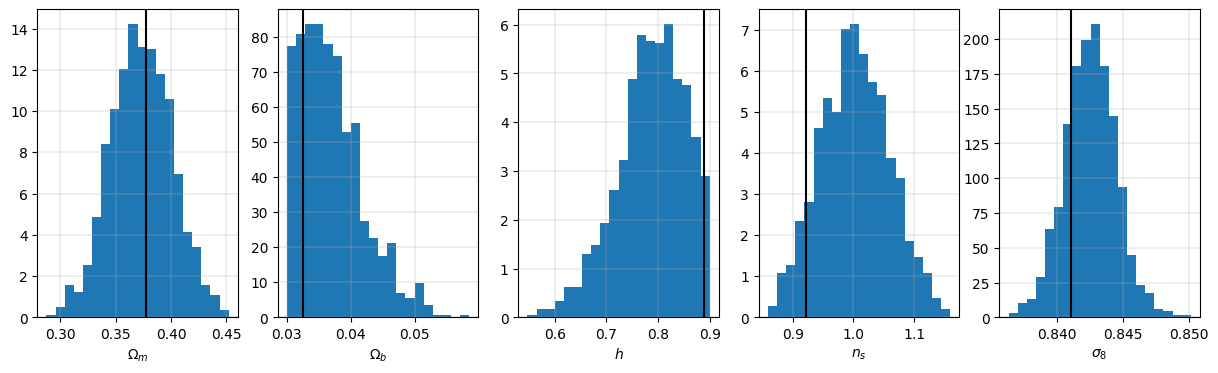

In [118]:
idx = 10
samples_params = posterior.sample((1000,), x=torch.from_numpy(test_x[idx])).numpy()

fig, ax = plt.subplots(1, 5, figsize=(15, 4))

for i in range(5):
    ax[i].hist(samples_params[:, i], density=True, bins=20)
    ax[i].axvline(test_p[idx, i], color='k')
    ax[i].set_xlabel(cosmonames[i])
    ax[i].grid(lw=0.3)

    # # we can also plot priors to see how much does our data constrain the parameters
    # ax[i].axvline(params.min(axis=0)[i], color='r', ls='--')
    # ax[i].axvline(params.max(axis=0)[i], color='r', ls='--')


We can also make a corner plot to visualize a 2-dimensional distribution of posteriors. For this, we will use the corner package.  

In [122]:
# lets install it first
!pip install --quiet corner


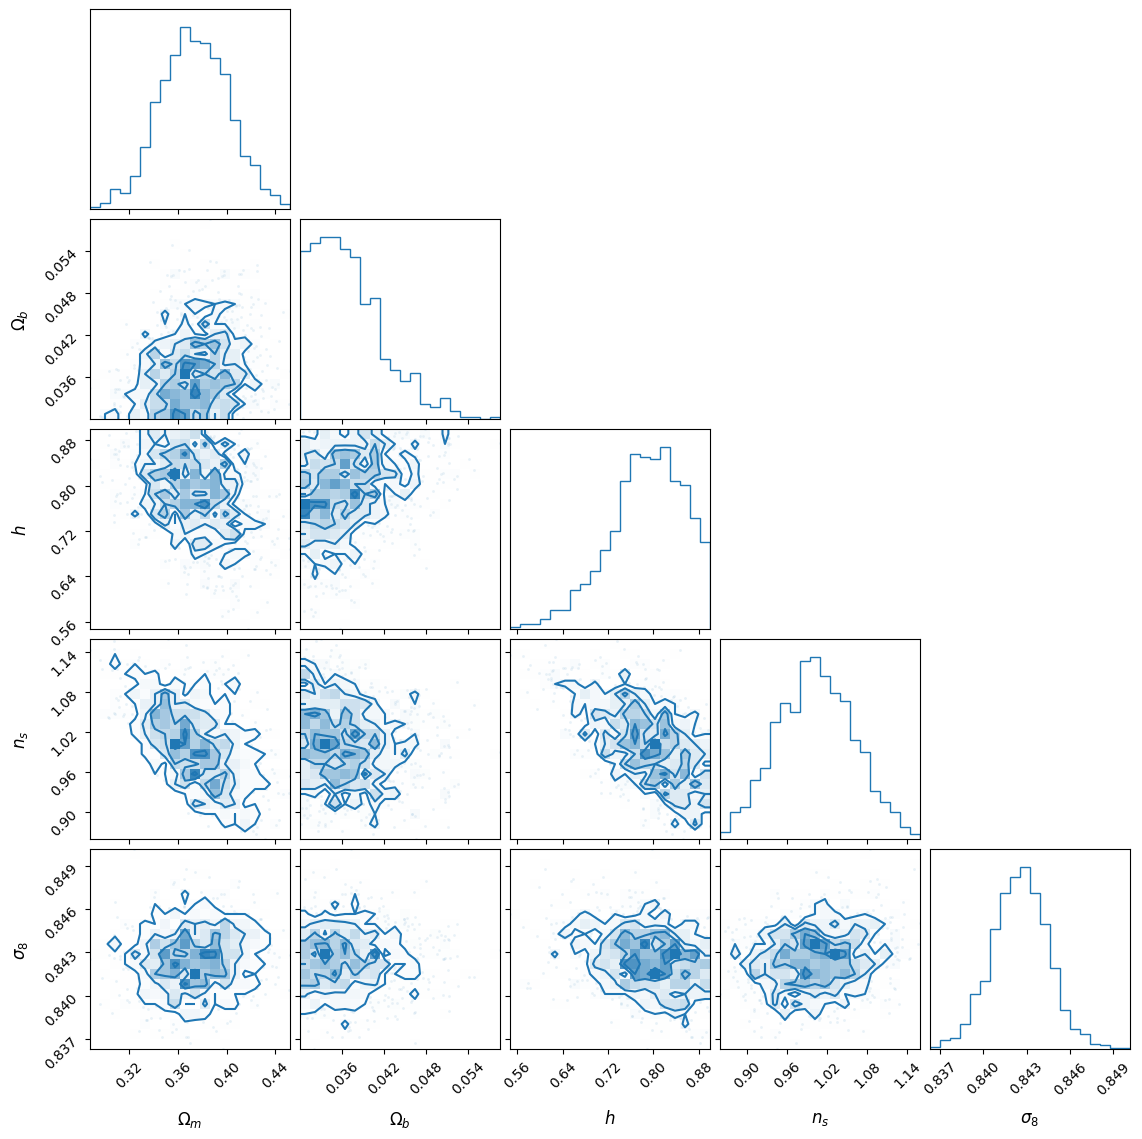

In [133]:
import corner

fig = corner.corner(samples_params,
                    labels=cosmonames,
                    label_kwargs={'fontsize': 12},
                    color='C0', hist_kwargs={'density': True})


# Simulation based calibration


Okay, now we have a trained SBI algorithm and given any new data point, we can use it to get a "posterior distribution". But how do we know it is correct?

Validation is _critical_.

*This is not specific to SBI, but instead it is true for all Bayesian inference approaches.*

Unfortunately, there are no methods of validation that guarantee your posteriors are correct. There are a few necessary but not sufficient tests that you can do, i.e. if these tests fail, then you know that the posterior is not correct. However if these tests pass, they only inspire some confidence that the answer is correct, but do not guarantee it.

There are 3 tests for doing this-
- Coverage test (simulation based caliberation, SBC) (https://arxiv.org/abs/1804.06788)
- TARP (distance to a random point) (https://arxiv.org/abs/2302.03026)
- Classifier basd method (https://arxiv.org/abs/2305.14593)


Here we will perform the coverage test based on Talts et.al. Broadly, the idea is: the distribution of the rank of the true parameters sampled from the prior, with respect to the samples from the corresponding posterior, should be a uniform distribution.

This can be broken down into following steps:

- draw a sample from prior $\tilde \theta \sim p(\theta)$
- simulate a data - $\tilde x \sim p(x|\tilde  \theta)$
- draw samples from the posterior $\theta_{i=1..N} \sim p(\theta | \tilde x)$
- find the rank of the true parameters in these posterior samples $rank = \sum\mathbb{1} (\theta_i < \tilde \theta)$
- plot the distribution of ranks (histogram) for every parameter. If the inference is well calibrated, then this distribution should be a uniform distribution.


This can be generalized to find rank of any statistic (see paper).


To implement this in our case, we will use the held out test dataset, which is essentially the samples from the likelihood distribution (step 1 and 2 above) and will implement the remaining steps below.

In [134]:
def get_ranks(params, x, posterior, nsamples=500):

    ndim = params.shape[1]
    ranks = []

    # loop over all the data points and generate samples.
    for i in range(x.shape[0]):
        # generate samples
        posterior_samples =  posterior.sample((nsamples,),
                                    x=torch.from_numpy(x[i].astype('float32')),
                                    show_progress_bars=False).detach().numpy()
        # estimate the rank for each of the 5 sampled parameter
        rank = [(posterior_samples[:, j] < params[i, j]).sum() for j in range(ndim)]
        #save ranks
        ranks.append(rank)

    return np.array(ranks)

# estimate the ranks on the held our test dataset
ranks = get_ranks(test_p, test_x, posterior)

 Now we can plot the histogram of this rank distribution to see if it is a uniform distribution.

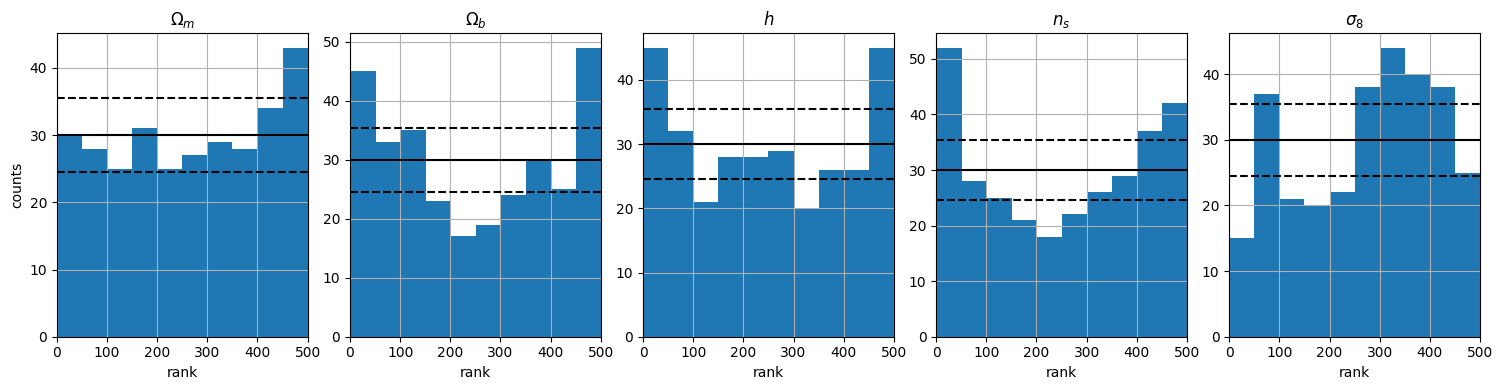

In [135]:
# number of bins in the histogram
nbins = 10
ncounts = ranks.shape[0]/nbins

fig, ax = plt.subplots(1, 5, figsize=(15, 4))

for i in range(5):
    ax[i].hist(np.array(ranks)[:, i], bins=nbins)
    ax[i].set_title(cosmonames[i])
    ax[0].set_ylabel('counts')

for axis in ax:
    axis.set_xlim(0, ranks.max())
    axis.set_xlabel('rank')
    axis.grid(visible=True)

    # lets plot the expected counts for a uniform distribution given the number of samples we have
    axis.axhline(ncounts, color='k')
    # let us also plot the Poisson errors around it.
    axis.axhline(ncounts - ncounts**0.5, color='k', ls="--")
    axis.axhline(ncounts + ncounts**0.5, color='k', ls="--")
plt.tight_layout()


# What next?

Training flows is very stochastic. You probably want to train multiple of these and combine them together to form an _ensemble of flows_. Think of it as mixture distribution where every component is a flow.

This helps to get calibrated posteriors.

A good package for doing this kind of hyperparameter search (in this setting or other ML settings as well) is weights and biases (https://wandb.ai/), though there are many other packages as well.